# Accessing PHE Covid Data

[Public Health England](https://www.gov.uk/government/organisations/public-health-england) (PHE) is one of many Institutions worldwide running a Coronavirus [dashboard](https://coronavirus.data.gov.uk/), with current statistics on the pandemic. In this series of notebooks, we will guide you through creating your own simple dashboard based on PHE data and putting it online as a [Binder](https://mybinder.org/).

You want to start by clicking on *Developer's<sup>1</sup> Guide* in the dashboard menu, which will take you straight to the  [API documentation](https://coronavirus.data.gov.uk/developers-guide). This will be your main source of information for this project, as far as the interaction with the PHE servers is concerned.

<sup>1</sup> *Developer*: that's you!

## The web-based API and the SDK

Many websites support access to their underlying data through a web-based [Application Programming Interface](https://en.wikipedia.org/wiki/API) (an API for short). This is often based on the *http* protocol, and may involve the excange of information in [JSON format](https://en.wikipedia.org/wiki/JSON). Specifically, using a web-based API typically involves sending *http* requests with parameters conforming to a given schema to a dedicated URL (the API *endpoint*), to which the server responds with JSON content. All this is specified in the PHE [API documentation](https://coronavirus.data.gov.uk/developers-guide).

As you can see from the documentation, PHE actually also offers a Python Software Devekopment Kit (SDK). This is a Python wrapper that facilitates access to the API by building the requests for you, forwarding them to the API access point and packaging the response into some convenient format. The PHE [Pyhton SDK](https://pypi.org/project/uk-covid19/) is found on the standard Python package repository, PyPi.

The first step, therefore, consists in installing the Python SDK. This will depend on how you are accessing these matierials.

* If you are working in a Binder: the SDK is already installed for you.
* On the EECS JupyterHub: open a terminal, then enter the following commands (note the double minus ```--```):
```
pip install --user uk-covid19
```
you can then close the terminal (type ```exit``` and close the tab).
* On your local machine: this depends on your setup. Entering this line in a command shell will hopefully work:
```
pip install uk-covid19
```
if it doesn't, try searching the documentation of your Python distribution or Google for instructions on how to install PiPy packages on your machine. 

If you have successfully  installed the SDK in your environment, the following cell should work:

In [26]:
# note the name of the module has an underscore in place of the -
from uk_covid19 import Cov19API
import json

## Accessing the API through the SDK

We are now ready to download data from the server via the SDK. Before continuing, you should have a look at the [SDK documentation](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk/index.html), which will refer you to the general [API documentation](https://coronavirus.data.gov.uk/developers-guide) for the meaning of the main parameters. The examples below follow the documentation closely.

According to the documentation, the first step is defining a [*filter*](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk/pages/examples/general_use.html#filters) - this is a **list** specifiying an *areaType* parameter and an optional *areaName*, *areaCode* and *date* parameters. In the jargon of the documentation, these parameters are called *metrics* - check out the metrics allowed for filters [here](https://coronavirus.data.gov.uk/developers-guide#params-filters).

In [2]:
filters = [
    'areaType=overview'
    # note each metric-value pair is inside one string
]

Next, you want do define a [*structure*](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk/pages/examples/general_use.html#structure). According to the SDK ocumentation, this is a **dictionary** that specifies which data fields you want to request. In fact, looking at the API documentation for [structures](https://coronavirus.data.gov.uk/developers-guide#params-structure) shows that they do more: they also specify the "format" in which you want to receive the response. Read the documentation carefully, including the list of valid *metrics* for a *structure* (which is in fact the most important part).

The structure below selects the metrics (that is, the PHE database fields) given as values of the dictionary, and at the same time instructs the API to rename the fields to the simpler names given as keys before serving them to us.

In [3]:
# values here are the names of the PHE metrics
structure = {
    "date": "date",
    "cases": "newCasesByPublishDate",
    "hospital": "newAdmissions",
    "deaths": "cumDeaths28DaysByDeathDateRate"    
}

Accessing the API is easy at this point. You just need to create a ```Cov19API``` object by passing the filters and structure to its constructor, as follows:

In [4]:
api = Cov19API(filters=filters, structure=structure)

Finally, calling the ```get_json()``` method of the ```api``` object actually sends the request to the API and retrieves the response (theoretically) in JSON format.

In [5]:
# NOTE: this call polls the server. It may fail in case of connectivity problems or if the data
# are not available for any reason. It will also fail if the metric in the structure are not compatible
# with the filters (eg they are not defined at the national or local level).
timeseries=api.get_json()

In [6]:
print(timeseries)

{'data': [{'date': '2020-10-20', 'cases': 21331, 'hospital': None, 'deaths': None}, {'date': '2020-10-19', 'cases': 18804, 'hospital': None, 'deaths': 65.8}, {'date': '2020-10-18', 'cases': 16982, 'hospital': None, 'deaths': None}, {'date': '2020-10-17', 'cases': 16171, 'hospital': None, 'deaths': 65.6}, {'date': '2020-10-16', 'cases': 15650, 'hospital': 860, 'deaths': 65.4}, {'date': '2020-10-15', 'cases': 18980, 'hospital': 1019, 'deaths': 65.2}, {'date': '2020-10-14', 'cases': 19724, 'hospital': 930, 'deaths': 65.1}, {'date': '2020-10-13', 'cases': 17234, 'hospital': 992, 'deaths': 64.9}, {'date': '2020-10-12', 'cases': 13972, 'hospital': 848, 'deaths': 64.7}, {'date': '2020-10-11', 'cases': 12872, 'hospital': 799, 'deaths': 64.6}, {'date': '2020-10-10', 'cases': 15166, 'hospital': 691, 'deaths': 64.4}, {'date': '2020-10-09', 'cases': 13864, 'hospital': 677, 'deaths': 64.2}, {'date': '2020-10-08', 'cases': 17540, 'hospital': 678, 'deaths': 64.1}, {'date': '2020-10-07', 'cases': 1416

In [7]:
print(type(timeseries)) # hold on, this is not JSON!

<class 'dict'>


As you can see, ```get_json()``` is a bit of a misnomer - the function actually returns a dictionary containing nested lists and dictionaries. As we will see this is not too different from what a JSON string looks like, but technically, this is something different. All the better for us, we don't need to decode it - but we may actually want to encode it, see below.

Also, some entries contain a value of ```None```, we will asssume that stands for a ```0``` rather than for not available. In any case, by and large we got our data, so this is a success.

### Another example: Cases by gender and age

The example above lends itself to visualisation as a plot of cases, hospital admissions and fatalities vs time. In this example, instead, we investigate the distribution of cases by sex and age bands; eventually, we will plot this as a bar chart.

Again we define our *filters* and *structure*, but with different *metrics*, as follows: 

In [8]:
filters = [
    'areaType=nation',
    'areaName=England'
]


# values here are the names of the PHE metrics
structure = {
    "males": "maleCases",
    "females": "femaleCases"
}

The next two steps are standard:

In [9]:
api = Cov19API(filters=filters, structure=structure)

In [10]:
# NOTE: this call polls the server. It may fail in case of connectivity problems or if the data
# are not available for any reason. It will also fail if the metric in the structure are not compatible
# with the filters (eg they are not defined at the national or local level).
agedistribution=api.get_json()

In [11]:
print(agedistribution)

{'data': [{'males': [{'age': '30_to_34', 'value': 22377, 'rate': 1157.6}, {'age': '80_to_84', 'value': 11182, 'rate': 1759.7}, {'age': '50_to_54', 'value': 20989, 'rate': 1141.1}, {'age': '60_to_64', 'value': 15368, 'rate': 1006.3}, {'age': '15_to_19', 'value': 26236, 'rate': 1525.8}, {'age': '70_to_74', 'value': 10873, 'rate': 817.4}, {'age': '35_to_39', 'value': 19981, 'rate': 1051.3}, {'age': '20_to_24', 'value': 30049, 'rate': 1892.6}, {'age': '65_to_69', 'value': 11226, 'rate': 829.8}, {'age': '25_to_29', 'value': 23697, 'rate': 1321.8}, {'age': '10_to_14', 'value': 7340, 'rate': 405.0}, {'age': '40_to_44', 'value': 18122, 'rate': 980.0}, {'age': '85_to_89', 'value': 9451, 'rate': 2693.7}, {'age': '75_to_79', 'value': 10530, 'rate': 1169.1}, {'age': '55_to_59', 'value': 19541, 'rate': 1014.1}, {'age': '5_to_9', 'value': 4493, 'rate': 248.3}, {'age': '45_to_49', 'value': 19376, 'rate': 1139.6}, {'age': '0_to_4', 'value': 4650, 'rate': 274.6}, {'age': '90+', 'value': 6667, 'rate': 4

Again this is a dictionary and it does contain the data we expected. Note however how the formatting and the type of data depend, maybe unsurprisingly, on the specific *metric* we queried.

## Saving the data in JSON format

At this point, we want to save the result of our API queries in order to 
* have something definite to work on in the other notebooks
* eventually, give our dashboard some starting data.

The problem arises of how to save these dictionaries to the disk. Luckily we do not have to save them in a bespoke way at this stage - we can use the [json module](https://docs.python.org/3/library/json.html) in the stardard library to dump them sa they are in [JSON format](https://en.wikipedia.org/wiki/JSON). This is straightforward:

In [12]:
import json

In [13]:
with open("timeseries.json", "wt") as OUTF:
    json.dump(timeseries, OUTF)

In [14]:
with open("agedistribution.json", "wt") as OUTF:
    json.dump(agedistribution, OUTF)

If you now use a text editor (or the Jupyter Notebook interface), you will see that the content of the files closely resembles the tangle of dictionaries and lists we have seen above. However, technically, these are no longer Python dictionary and files, rather the JSON representation of them, and could be opened by another program written in another language, that will map them to an equivalent data structure (whichever is provided by that language).

## Your turn

Explore the various *metrics* available for [*filters*](https://coronavirus.data.gov.uk/developers-guide#params-filters) and [*structures*](https://coronavirus.data.gov.uk/developers-guide#params-structure) and think of a query that may be of interest to you, and how you might then want to visualise the data. You can modify either the *structure*, in order to select different types of data, or the *filters*, to specify a different granularity (national or local level, specific dates, etc). Possible graphs of interest might be:
* a comparison of the number of test carried out with planned testing capacity;
* a comparison of the number of new cases with the number of tests;
* the above, broken down by region;
* a comparison of the number of cases with hospital admissions;
* a comparison of hospital admissions with ventilator bed occupancy;
* new cases in major cities as a fraction of the population of those cities;
* a comparison of the age distribution of new cases at different times (this will require more than one API access)

Please keep in mind the following points:
* Not all metrics are available for all dates, or at all levels of granularity; querying for data that's unavailable will result in an error.
* Documentation is poor - welcome to the real world. A BSc in Reverse Engineering would come in handy.
* Experimenting is fine. However, avoid flooding the server with multiple queries at machine speed - if you use a ```for``` loop to generate API accesses, use the ```sleep()``` function from the ```time``` module to introduce a 1 second delay between one query and the next (see [here](https://docs.python.org/3/library/time.html#time.sleep) for details). The last thing you want is for PHE to ban you.

Once you succeed in retrieving the data you want, save them in JSON format and move on to the next stage - visualisation.


**NOTE:** In the visualisation stage, we are going to load the data into a ```pandas.DataFrame``` structure. As you will see from the documentation, the SDK contains a method ```get_dataframe()``` that allows you to retrieve the data in the form of a ```DataFrame``` directly. From my tests, however, this method only works with certain *metrics*, and returns gibberish in other cases. I would therefore advise you to stick with JSON. In any case, JSON is a de-facto standard for APIs, and some familiarity with this format is a valuable skill in itself.

# NW deaths

In [102]:
from uk_covid19 import Cov19API
import json

filters = ['areaType=region', 'areaName=North West']

structure = {
    "date": "date",
    "Cases": "newCasesBySpecimenDate",
    "Ventilators": "covidOccupiedMVBeds",
    "Deaths": "newDeathsByDeathDate",  

}
api = Cov19API(filters=filters, structure=structure)
NW=api.get_json()
print(NW)
import json
with open("NW.json", "wt") as OUTF:
    json.dump(NW, OUTF)

{'data': [{'date': '2020-10-20', 'Cases': 32, 'Ventilators': None, 'Deaths': 15}, {'date': '2020-10-19', 'Cases': 4576, 'Ventilators': None, 'Deaths': 36}, {'date': '2020-10-18', 'Cases': 3047, 'Ventilators': None, 'Deaths': 43}, {'date': '2020-10-17', 'Cases': 3492, 'Ventilators': None, 'Deaths': 57}, {'date': '2020-10-16', 'Cases': 3836, 'Ventilators': None, 'Deaths': 42}, {'date': '2020-10-15', 'Cases': 4138, 'Ventilators': None, 'Deaths': 42}, {'date': '2020-10-14', 'Cases': 4480, 'Ventilators': None, 'Deaths': 41}, {'date': '2020-10-13', 'Cases': 4260, 'Ventilators': None, 'Deaths': 30}, {'date': '2020-10-12', 'Cases': 4734, 'Ventilators': None, 'Deaths': 49}, {'date': '2020-10-11', 'Cases': 2929, 'Ventilators': None, 'Deaths': 37}, {'date': '2020-10-10', 'Cases': 2962, 'Ventilators': None, 'Deaths': 44}, {'date': '2020-10-09', 'Cases': 3731, 'Ventilators': None, 'Deaths': 32}, {'date': '2020-10-08', 'Cases': 4248, 'Ventilators': None, 'Deaths': 30}, {'date': '2020-10-07', 'Cases'

In [103]:
#NW
import pandas as pd
import matplotlib.pyplot as plt
import json
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

with open("NW.json", "rt") as INFILE:
    data=json.load(INFILE)
data

{'data': [{'date': '2020-10-20',
   'Cases': 32,
   'Ventilators': None,
   'Deaths': 15},
  {'date': '2020-10-19', 'Cases': 4576, 'Ventilators': None, 'Deaths': 36},
  {'date': '2020-10-18', 'Cases': 3047, 'Ventilators': None, 'Deaths': 43},
  {'date': '2020-10-17', 'Cases': 3492, 'Ventilators': None, 'Deaths': 57},
  {'date': '2020-10-16', 'Cases': 3836, 'Ventilators': None, 'Deaths': 42},
  {'date': '2020-10-15', 'Cases': 4138, 'Ventilators': None, 'Deaths': 42},
  {'date': '2020-10-14', 'Cases': 4480, 'Ventilators': None, 'Deaths': 41},
  {'date': '2020-10-13', 'Cases': 4260, 'Ventilators': None, 'Deaths': 30},
  {'date': '2020-10-12', 'Cases': 4734, 'Ventilators': None, 'Deaths': 49},
  {'date': '2020-10-11', 'Cases': 2929, 'Ventilators': None, 'Deaths': 37},
  {'date': '2020-10-10', 'Cases': 2962, 'Ventilators': None, 'Deaths': 44},
  {'date': '2020-10-09', 'Cases': 3731, 'Ventilators': None, 'Deaths': 32},
  {'date': '2020-10-08', 'Cases': 4248, 'Ventilators': None, 'Deaths': 30

In [104]:
datalist=data['data']
datalist

[{'date': '2020-10-20', 'Cases': 32, 'Ventilators': None, 'Deaths': 15},
 {'date': '2020-10-19', 'Cases': 4576, 'Ventilators': None, 'Deaths': 36},
 {'date': '2020-10-18', 'Cases': 3047, 'Ventilators': None, 'Deaths': 43},
 {'date': '2020-10-17', 'Cases': 3492, 'Ventilators': None, 'Deaths': 57},
 {'date': '2020-10-16', 'Cases': 3836, 'Ventilators': None, 'Deaths': 42},
 {'date': '2020-10-15', 'Cases': 4138, 'Ventilators': None, 'Deaths': 42},
 {'date': '2020-10-14', 'Cases': 4480, 'Ventilators': None, 'Deaths': 41},
 {'date': '2020-10-13', 'Cases': 4260, 'Ventilators': None, 'Deaths': 30},
 {'date': '2020-10-12', 'Cases': 4734, 'Ventilators': None, 'Deaths': 49},
 {'date': '2020-10-11', 'Cases': 2929, 'Ventilators': None, 'Deaths': 37},
 {'date': '2020-10-10', 'Cases': 2962, 'Ventilators': None, 'Deaths': 44},
 {'date': '2020-10-09', 'Cases': 3731, 'Ventilators': None, 'Deaths': 32},
 {'date': '2020-10-08', 'Cases': 4248, 'Ventilators': None, 'Deaths': 30},
 {'date': '2020-10-07', 'Ca

In [105]:
dates=[dictionary['date'] for dictionary in datalist ]
dates.sort()
dates

['2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26',
 '2020-04-27',
 '2020-04-28',
 '2020-04-29',
 '2020-04-30',
 '2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-

In [106]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [107]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2020-02-28 00:00:00  to  2020-10-20 00:00:00


In [108]:
index=pd.date_range(startdate, enddate, freq='D')
NWdf=pd.DataFrame(index=index, columns=['Cases', 'Ventilators', 'Deaths'])
NWdf

,Cases,Ventilators,Deaths
2020-02-28,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN
2020-03-02,NaN,NaN,NaN
2020-03-03,NaN,NaN,NaN
...,...,...,...
2020-10-16,NaN,NaN,NaN
2020-10-17,NaN,NaN,NaN
2020-10-18,NaN,NaN,NaN
2020-10-19,NaN,NaN,NaN


In [109]:
for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
    date=parse_date(entry['date'])
    for column in ['Cases', 'Ventilators', 'Deaths']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
        if pd.isna(NWdf.loc[date, column]): 
            # replace None with 0 in our data 
            value= float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            NWdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
NWdf.fillna(0.0, inplace=True)
            
NWdf

,Cases,Ventilators,Deaths
2020-02-28,1.0,0.0,0.0
2020-02-29,0.0,0.0,0.0
2020-03-01,7.0,0.0,0.0
2020-03-02,6.0,0.0,0.0
2020-03-03,7.0,0.0,0.0
...,...,...,...
2020-10-16,3836.0,0.0,42.0
2020-10-17,3492.0,0.0,57.0
2020-10-18,3047.0,0.0,43.0
2020-10-19,4576.0,0.0,36.0


Text(0, 0.5, 'Cases')

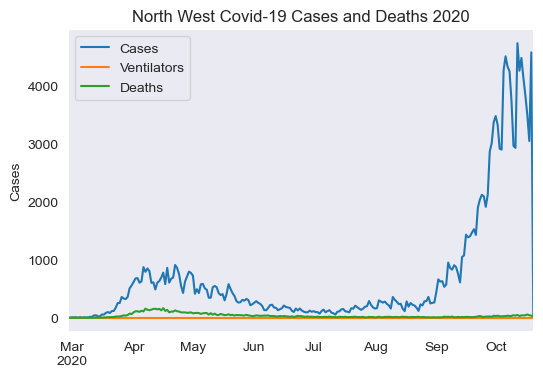

In [134]:
import seaborn as sns
sns.set_style("dark")
NWdf.plot()
plt.title("North West Covid-19 Cases and Deaths 2020")
plt.ylabel("Cases")

Text(0, 0.5, 'Cases in Log')

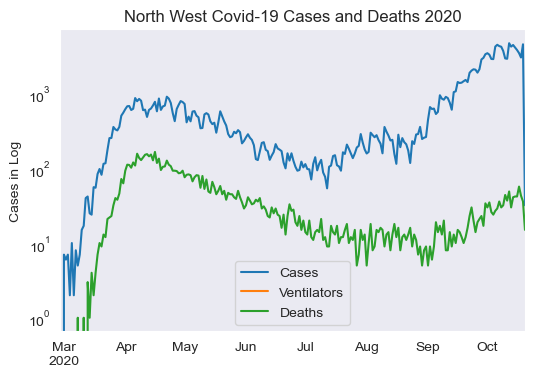

In [137]:
import seaborn as sns
sns.set_style("dark")
NWdf.plot(logy=True)
plt.title("North West Covid-19 Cases and Deaths 2020")
plt.ylabel("Cases in Log")

# LONDON cases

In [112]:
from uk_covid19 import Cov19API
import json

filters = ['areaType=region','areaName=London']

structure = {
    "date": "date",
    "Cases": "newCasesBySpecimenDate",
    "Ventilators": "covidOccupiedMVBeds",
    "Deaths": "newDeathsByDeathDate",  


}
api = Cov19API(filters=filters, structure=structure)
London=api.get_json()
print(London)
import json
with open("London.json", "wt") as OUTF:
    json.dump(London, OUTF)

{'data': [{'date': '2020-10-20', 'Cases': 24, 'Ventilators': None, 'Deaths': 2}, {'date': '2020-10-19', 'Cases': 1529, 'Ventilators': None, 'Deaths': 7}, {'date': '2020-10-18', 'Cases': 1177, 'Ventilators': None, 'Deaths': 5}, {'date': '2020-10-17', 'Cases': 1014, 'Ventilators': None, 'Deaths': 4}, {'date': '2020-10-16', 'Cases': 1649, 'Ventilators': None, 'Deaths': 6}, {'date': '2020-10-15', 'Cases': 1678, 'Ventilators': None, 'Deaths': 16}, {'date': '2020-10-14', 'Cases': 1650, 'Ventilators': None, 'Deaths': 6}, {'date': '2020-10-13', 'Cases': 1522, 'Ventilators': None, 'Deaths': 7}, {'date': '2020-10-12', 'Cases': 1610, 'Ventilators': None, 'Deaths': 7}, {'date': '2020-10-11', 'Cases': 793, 'Ventilators': None, 'Deaths': 7}, {'date': '2020-10-10', 'Cases': 923, 'Ventilators': None, 'Deaths': 5}, {'date': '2020-10-09', 'Cases': 1395, 'Ventilators': None, 'Deaths': 12}, {'date': '2020-10-08', 'Cases': 1572, 'Ventilators': None, 'Deaths': 11}, {'date': '2020-10-07', 'Cases': 1530, 'Ven

In [114]:
#London VISUALISING THE DATA
import pandas as pd
import matplotlib.pyplot as plt
import json
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

with open("London.json", "rt") as INFILE:
    data=json.load(INFILE)
data

{'data': [{'date': '2020-10-20',
   'Cases': 24,
   'Ventilators': None,
   'Deaths': 2},
  {'date': '2020-10-19', 'Cases': 1529, 'Ventilators': None, 'Deaths': 7},
  {'date': '2020-10-18', 'Cases': 1177, 'Ventilators': None, 'Deaths': 5},
  {'date': '2020-10-17', 'Cases': 1014, 'Ventilators': None, 'Deaths': 4},
  {'date': '2020-10-16', 'Cases': 1649, 'Ventilators': None, 'Deaths': 6},
  {'date': '2020-10-15', 'Cases': 1678, 'Ventilators': None, 'Deaths': 16},
  {'date': '2020-10-14', 'Cases': 1650, 'Ventilators': None, 'Deaths': 6},
  {'date': '2020-10-13', 'Cases': 1522, 'Ventilators': None, 'Deaths': 7},
  {'date': '2020-10-12', 'Cases': 1610, 'Ventilators': None, 'Deaths': 7},
  {'date': '2020-10-11', 'Cases': 793, 'Ventilators': None, 'Deaths': 7},
  {'date': '2020-10-10', 'Cases': 923, 'Ventilators': None, 'Deaths': 5},
  {'date': '2020-10-09', 'Cases': 1395, 'Ventilators': None, 'Deaths': 12},
  {'date': '2020-10-08', 'Cases': 1572, 'Ventilators': None, 'Deaths': 11},
  {'date'

In [115]:
datalist=data['data']
datalist

[{'date': '2020-10-20', 'Cases': 24, 'Ventilators': None, 'Deaths': 2},
 {'date': '2020-10-19', 'Cases': 1529, 'Ventilators': None, 'Deaths': 7},
 {'date': '2020-10-18', 'Cases': 1177, 'Ventilators': None, 'Deaths': 5},
 {'date': '2020-10-17', 'Cases': 1014, 'Ventilators': None, 'Deaths': 4},
 {'date': '2020-10-16', 'Cases': 1649, 'Ventilators': None, 'Deaths': 6},
 {'date': '2020-10-15', 'Cases': 1678, 'Ventilators': None, 'Deaths': 16},
 {'date': '2020-10-14', 'Cases': 1650, 'Ventilators': None, 'Deaths': 6},
 {'date': '2020-10-13', 'Cases': 1522, 'Ventilators': None, 'Deaths': 7},
 {'date': '2020-10-12', 'Cases': 1610, 'Ventilators': None, 'Deaths': 7},
 {'date': '2020-10-11', 'Cases': 793, 'Ventilators': None, 'Deaths': 7},
 {'date': '2020-10-10', 'Cases': 923, 'Ventilators': None, 'Deaths': 5},
 {'date': '2020-10-09', 'Cases': 1395, 'Ventilators': None, 'Deaths': 12},
 {'date': '2020-10-08', 'Cases': 1572, 'Ventilators': None, 'Deaths': 11},
 {'date': '2020-10-07', 'Cases': 1530, 

In [116]:
dates=[dictionary['date'] for dictionary in datalist ]
dates.sort()
dates

['2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-

In [117]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [118]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2020-02-11 00:00:00  to  2020-10-20 00:00:00


In [119]:
index=pd.date_range(startdate, enddate, freq='D')
Londondf=pd.DataFrame(index=index, columns=['Cases', 'Ventilators', 'Deaths'])
Londondf

,Cases,Ventilators,Deaths
2020-02-11,NaN,NaN,NaN
2020-02-12,NaN,NaN,NaN
2020-02-13,NaN,NaN,NaN
2020-02-14,NaN,NaN,NaN
2020-02-15,NaN,NaN,NaN
...,...,...,...
2020-10-16,NaN,NaN,NaN
2020-10-17,NaN,NaN,NaN
2020-10-18,NaN,NaN,NaN
2020-10-19,NaN,NaN,NaN


In [120]:
for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
    date=parse_date(entry['date'])
    for column in ['Cases', 'Ventilators', 'Deaths']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
        if pd.isna(Londondf.loc[date, column]): 
            # replace None with 0 in our data 
            value= float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            Londondf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
Londondf.fillna(0.0, inplace=True)
            
Londondf

,Cases,Ventilators,Deaths
2020-02-11,1.0,0.0,0.0
2020-02-12,0.0,0.0,0.0
2020-02-13,0.0,0.0,0.0
2020-02-14,0.0,0.0,0.0
2020-02-15,0.0,0.0,0.0
...,...,...,...
2020-10-16,1649.0,0.0,6.0
2020-10-17,1014.0,0.0,4.0
2020-10-18,1177.0,0.0,5.0
2020-10-19,1529.0,0.0,7.0


Text(0, 0.5, 'Cases')

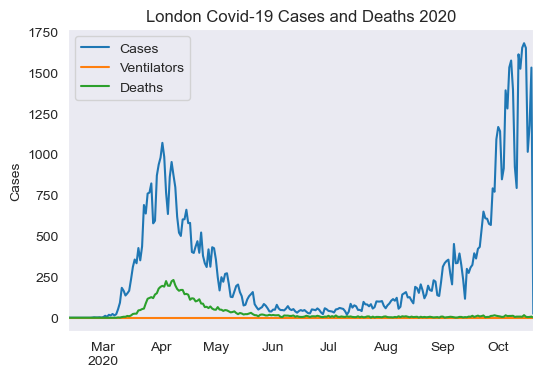

In [129]:
import seaborn as sns
sns.set_style("dark")
Londondf.plot()
plt.title("London Covid-19 Cases and Deaths 2020")
plt.ylabel("Cases")

Text(0, 0.5, 'Cases in Log')

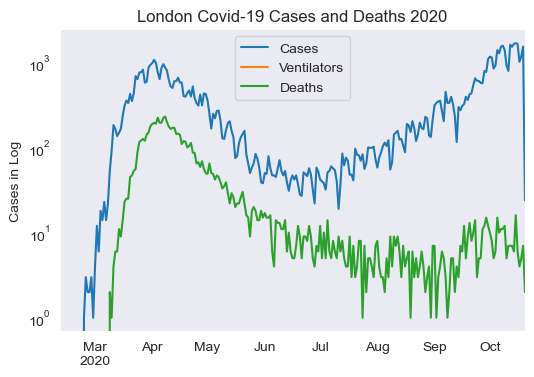

In [128]:
import seaborn as sns
sns.set_style("dark")
Londondf.plot(logy=True)
plt.title("London Covid-19 Cases and Deaths 2020")
plt.ylabel("Cases in Log")

# NW age

In [31]:
from uk_covid19 import Cov19API
import json

filters = ['areaType=region', 'areaName=North West']

structure = {
    "Males": "maleCases",
    "Females": "femaleCases"
}
api = Cov19API(filters=filters, structure=structure)
NWage=api.get_json()
print(NWage)
import json
with open("NWage.json", "wt") as OUTF:
    json.dump(NWage, OUTF)

{'data': [{'Males': [{'age': '55_to_59', 'value': 5394, 'rate': 2133.5}, {'age': '25_to_29', 'value': 6544, 'rate': 2738.2}, {'age': '70_to_74', 'value': 2774, 'rate': 1539.6}, {'age': '5_to_9', 'value': 1413, 'rate': 583.1}, {'age': '75_to_79', 'value': 2477, 'rate': 2048.0}, {'age': '60_to_64', 'value': 4214, 'rate': 2043.5}, {'age': '50_to_54', 'value': 5786, 'rate': 2468.2}, {'age': '30_to_34', 'value': 6030, 'rate': 2362.8}, {'age': '85_to_89', 'value': 1846, 'rate': 4259.3}, {'age': '10_to_14', 'value': 2517, 'rate': 1076.2}, {'age': '65_to_69', 'value': 3001, 'rate': 1621.4}, {'age': '20_to_24', 'value': 7557, 'rate': 3635.3}, {'age': '40_to_44', 'value': 4941, 'rate': 2158.4}, {'age': '15_to_19', 'value': 5985, 'rate': 2662.0}, {'age': '90+', 'value': 1102, 'rate': 5514.7}, {'age': '80_to_84', 'value': 2380, 'rate': 2860.5}, {'age': '0_to_4', 'value': 1326, 'rate': 601.0}, {'age': '35_to_39', 'value': 5456, 'rate': 2266.3}, {'age': '45_to_49', 'value': 5239, 'rate': 2542.6}], '

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [33]:
with open("NWage.json", "rt") as INFILE:
    data=json.load(INFILE)

In [34]:
datadic=data['data'][0] # data['data'] is a list
datadic

{'Males': [{'age': '55_to_59', 'value': 5394, 'rate': 2133.5},
  {'age': '25_to_29', 'value': 6544, 'rate': 2738.2},
  {'age': '70_to_74', 'value': 2774, 'rate': 1539.6},
  {'age': '5_to_9', 'value': 1413, 'rate': 583.1},
  {'age': '75_to_79', 'value': 2477, 'rate': 2048.0},
  {'age': '60_to_64', 'value': 4214, 'rate': 2043.5},
  {'age': '50_to_54', 'value': 5786, 'rate': 2468.2},
  {'age': '30_to_34', 'value': 6030, 'rate': 2362.8},
  {'age': '85_to_89', 'value': 1846, 'rate': 4259.3},
  {'age': '10_to_14', 'value': 2517, 'rate': 1076.2},
  {'age': '65_to_69', 'value': 3001, 'rate': 1621.4},
  {'age': '20_to_24', 'value': 7557, 'rate': 3635.3},
  {'age': '40_to_44', 'value': 4941, 'rate': 2158.4},
  {'age': '15_to_19', 'value': 5985, 'rate': 2662.0},
  {'age': '90+', 'value': 1102, 'rate': 5514.7},
  {'age': '80_to_84', 'value': 2380, 'rate': 2860.5},
  {'age': '0_to_4', 'value': 1326, 'rate': 601.0},
  {'age': '35_to_39', 'value': 5456, 'rate': 2266.3},
  {'age': '45_to_49', 'value':

In [35]:
datalist=data['data']
datalist

[{'Males': [{'age': '55_to_59', 'value': 5394, 'rate': 2133.5},
   {'age': '25_to_29', 'value': 6544, 'rate': 2738.2},
   {'age': '70_to_74', 'value': 2774, 'rate': 1539.6},
   {'age': '5_to_9', 'value': 1413, 'rate': 583.1},
   {'age': '75_to_79', 'value': 2477, 'rate': 2048.0},
   {'age': '60_to_64', 'value': 4214, 'rate': 2043.5},
   {'age': '50_to_54', 'value': 5786, 'rate': 2468.2},
   {'age': '30_to_34', 'value': 6030, 'rate': 2362.8},
   {'age': '85_to_89', 'value': 1846, 'rate': 4259.3},
   {'age': '10_to_14', 'value': 2517, 'rate': 1076.2},
   {'age': '65_to_69', 'value': 3001, 'rate': 1621.4},
   {'age': '20_to_24', 'value': 7557, 'rate': 3635.3},
   {'age': '40_to_44', 'value': 4941, 'rate': 2158.4},
   {'age': '15_to_19', 'value': 5985, 'rate': 2662.0},
   {'age': '90+', 'value': 1102, 'rate': 5514.7},
   {'age': '80_to_84', 'value': 2380, 'rate': 2860.5},
   {'age': '0_to_4', 'value': 1326, 'rate': 601.0},
   {'age': '35_to_39', 'value': 5456, 'rate': 2266.3},
   {'age': '

In [36]:
Males=datadic['Males']
Females=datadic['Females']
Males # females is similar 

[{'age': '55_to_59', 'value': 5394, 'rate': 2133.5},
 {'age': '25_to_29', 'value': 6544, 'rate': 2738.2},
 {'age': '70_to_74', 'value': 2774, 'rate': 1539.6},
 {'age': '5_to_9', 'value': 1413, 'rate': 583.1},
 {'age': '75_to_79', 'value': 2477, 'rate': 2048.0},
 {'age': '60_to_64', 'value': 4214, 'rate': 2043.5},
 {'age': '50_to_54', 'value': 5786, 'rate': 2468.2},
 {'age': '30_to_34', 'value': 6030, 'rate': 2362.8},
 {'age': '85_to_89', 'value': 1846, 'rate': 4259.3},
 {'age': '10_to_14', 'value': 2517, 'rate': 1076.2},
 {'age': '65_to_69', 'value': 3001, 'rate': 1621.4},
 {'age': '20_to_24', 'value': 7557, 'rate': 3635.3},
 {'age': '40_to_44', 'value': 4941, 'rate': 2158.4},
 {'age': '15_to_19', 'value': 5985, 'rate': 2662.0},
 {'age': '90+', 'value': 1102, 'rate': 5514.7},
 {'age': '80_to_84', 'value': 2380, 'rate': 2860.5},
 {'age': '0_to_4', 'value': 1326, 'rate': 601.0},
 {'age': '35_to_39', 'value': 5456, 'rate': 2266.3},
 {'age': '45_to_49', 'value': 5239, 'rate': 2542.6}]

In [37]:
ageranges=[x['age'] for x in Males] # each entry of males is a dictionary
print(ageranges)

['55_to_59', '25_to_29', '70_to_74', '5_to_9', '75_to_79', '60_to_64', '50_to_54', '30_to_34', '85_to_89', '10_to_14', '65_to_69', '20_to_24', '40_to_44', '15_to_19', '90+', '80_to_84', '0_to_4', '35_to_39', '45_to_49']


In [9]:
def min_age(agerange):
    agerange=agerange.replace('+','') # remove the + from 90+
    start=agerange.split('_')[0]
    return int(start)

print(min_age('85_to_89'))
print(min_age('90+')) # looking good...

85
90


In [48]:
ageranges.sort(key=min_age)
print (ageranges)

['0_to_4', '5_to_9', '10_to_14', '15_to_19', '20_to_24', '25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90+']


In [49]:
age_df=pd.DataFrame(index=ageranges, columns=['Males','Females', 'Total'])

In [50]:
for entry in males: # each entry is a dictionary
    ageband=entry['age'] # our index position
    age_df.loc[ageband, 'Males']=entry['value']
    
for entry in females:
    ageband=entry['age']
    age_df.loc[ageband, 'Females']=entry['value']
    
# this is straightforward
age_df['Total']=age_df['Males']+age_df['Females']

In [51]:
age_df

,Males,Females,Total
0_to_4,628,543,1171
5_to_9,545,484,1029
10_to_14,920,855,1775
15_to_19,2560,2922,5482
20_to_24,2855,3423,6278
25_to_29,3447,4504,7951
30_to_34,3580,3842,7422
35_to_39,2987,3017,6004
40_to_44,2559,2725,5284
45_to_49,2565,2795,5360


Text(0, 0.5, 'Cases')

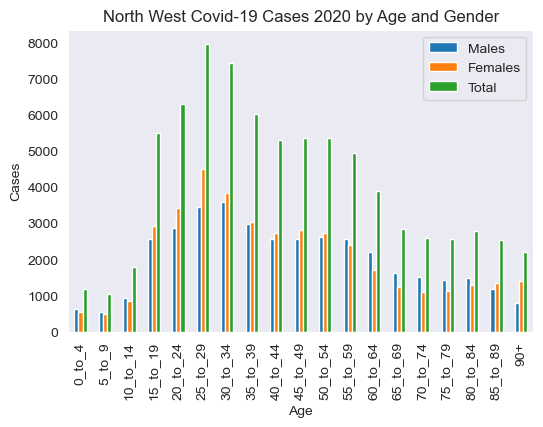

In [123]:
import seaborn as sns
sns.set_style("dark")
age_df.plot(kind='bar', y=['Males','Females','Total'])
plt.title("North West Covid-19 Cases 2020 by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Cases")


Text(0, 0.5, 'Cases')

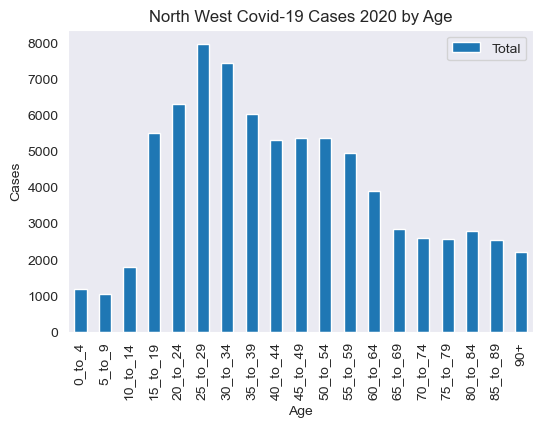

In [125]:
import seaborn as sns
sns.set_style("dark")
age_df.plot(kind='bar', y='Total')
plt.title("North West Covid-19 Cases 2020 by Age")
plt.xlabel("Age")
plt.ylabel("Cases")

# LONDON age

In [54]:
#LONDON
from uk_covid19 import Cov19API
import json

filters = ['areaType=region', 'areaName=London']

structure = {
    "Males": "maleCases",
    "Females": "femaleCases"
}
api = Cov19API(filters=filters, structure=structure)
LDNage=api.get_json()
print(LDNage)
import json
with open("LDNage.json", "wt") as OUTF:
    json.dump(LDNage, OUTF)

{'data': [{'Males': [{'age': '45_to_49', 'value': 2565, 'rate': 757.9}, {'age': '15_to_19', 'value': 2560, 'rate': 929.4}, {'age': '80_to_84', 'value': 1484, 'rate': 2264.6}, {'age': '85_to_89', 'value': 1187, 'rate': 3135.5}, {'age': '90+', 'value': 786, 'rate': 3990.3}, {'age': '70_to_74', 'value': 1513, 'rate': 1189.7}, {'age': '50_to_54', 'value': 2610, 'rate': 866.4}, {'age': '25_to_29', 'value': 3447, 'rate': 1216.0}, {'age': '0_to_4', 'value': 628, 'rate': 202.3}, {'age': '55_to_59', 'value': 2565, 'rate': 915.7}, {'age': '10_to_14', 'value': 920, 'rate': 297.9}, {'age': '40_to_44', 'value': 2559, 'rate': 632.8}, {'age': '30_to_34', 'value': 3580, 'rate': 931.7}, {'age': '20_to_24', 'value': 2855, 'rate': 1186.6}, {'age': '65_to_69', 'value': 1608, 'rate': 1085.3}, {'age': '75_to_79', 'value': 1440, 'rate': 1661.1}, {'age': '35_to_39', 'value': 2987, 'rate': 695.0}, {'age': '60_to_64', 'value': 2194, 'rate': 1148.6}, {'age': '5_to_9', 'value': 545, 'rate': 224.5}], 'Females': [{

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [56]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [57]:
with open("LDNage.json", "rt") as INFILE:
    data=json.load(INFILE)

In [58]:
datadic=data['data'][0] # data['data'] is a list
datadic

{'Males': [{'age': '45_to_49', 'value': 2565, 'rate': 757.9},
  {'age': '15_to_19', 'value': 2560, 'rate': 929.4},
  {'age': '80_to_84', 'value': 1484, 'rate': 2264.6},
  {'age': '85_to_89', 'value': 1187, 'rate': 3135.5},
  {'age': '90+', 'value': 786, 'rate': 3990.3},
  {'age': '70_to_74', 'value': 1513, 'rate': 1189.7},
  {'age': '50_to_54', 'value': 2610, 'rate': 866.4},
  {'age': '25_to_29', 'value': 3447, 'rate': 1216.0},
  {'age': '0_to_4', 'value': 628, 'rate': 202.3},
  {'age': '55_to_59', 'value': 2565, 'rate': 915.7},
  {'age': '10_to_14', 'value': 920, 'rate': 297.9},
  {'age': '40_to_44', 'value': 2559, 'rate': 632.8},
  {'age': '30_to_34', 'value': 3580, 'rate': 931.7},
  {'age': '20_to_24', 'value': 2855, 'rate': 1186.6},
  {'age': '65_to_69', 'value': 1608, 'rate': 1085.3},
  {'age': '75_to_79', 'value': 1440, 'rate': 1661.1},
  {'age': '35_to_39', 'value': 2987, 'rate': 695.0},
  {'age': '60_to_64', 'value': 2194, 'rate': 1148.6},
  {'age': '5_to_9', 'value': 545, 'rat

In [59]:
datalist=data['data']
datalist

[{'Males': [{'age': '45_to_49', 'value': 2565, 'rate': 757.9},
   {'age': '15_to_19', 'value': 2560, 'rate': 929.4},
   {'age': '80_to_84', 'value': 1484, 'rate': 2264.6},
   {'age': '85_to_89', 'value': 1187, 'rate': 3135.5},
   {'age': '90+', 'value': 786, 'rate': 3990.3},
   {'age': '70_to_74', 'value': 1513, 'rate': 1189.7},
   {'age': '50_to_54', 'value': 2610, 'rate': 866.4},
   {'age': '25_to_29', 'value': 3447, 'rate': 1216.0},
   {'age': '0_to_4', 'value': 628, 'rate': 202.3},
   {'age': '55_to_59', 'value': 2565, 'rate': 915.7},
   {'age': '10_to_14', 'value': 920, 'rate': 297.9},
   {'age': '40_to_44', 'value': 2559, 'rate': 632.8},
   {'age': '30_to_34', 'value': 3580, 'rate': 931.7},
   {'age': '20_to_24', 'value': 2855, 'rate': 1186.6},
   {'age': '65_to_69', 'value': 1608, 'rate': 1085.3},
   {'age': '75_to_79', 'value': 1440, 'rate': 1661.1},
   {'age': '35_to_39', 'value': 2987, 'rate': 695.0},
   {'age': '60_to_64', 'value': 2194, 'rate': 1148.6},
   {'age': '5_to_9',

In [60]:
Males=datadic['Males']
Females=datadic['Females']
Males # females is similar 

[{'age': '45_to_49', 'value': 2565, 'rate': 757.9},
 {'age': '15_to_19', 'value': 2560, 'rate': 929.4},
 {'age': '80_to_84', 'value': 1484, 'rate': 2264.6},
 {'age': '85_to_89', 'value': 1187, 'rate': 3135.5},
 {'age': '90+', 'value': 786, 'rate': 3990.3},
 {'age': '70_to_74', 'value': 1513, 'rate': 1189.7},
 {'age': '50_to_54', 'value': 2610, 'rate': 866.4},
 {'age': '25_to_29', 'value': 3447, 'rate': 1216.0},
 {'age': '0_to_4', 'value': 628, 'rate': 202.3},
 {'age': '55_to_59', 'value': 2565, 'rate': 915.7},
 {'age': '10_to_14', 'value': 920, 'rate': 297.9},
 {'age': '40_to_44', 'value': 2559, 'rate': 632.8},
 {'age': '30_to_34', 'value': 3580, 'rate': 931.7},
 {'age': '20_to_24', 'value': 2855, 'rate': 1186.6},
 {'age': '65_to_69', 'value': 1608, 'rate': 1085.3},
 {'age': '75_to_79', 'value': 1440, 'rate': 1661.1},
 {'age': '35_to_39', 'value': 2987, 'rate': 695.0},
 {'age': '60_to_64', 'value': 2194, 'rate': 1148.6},
 {'age': '5_to_9', 'value': 545, 'rate': 224.5}]

In [61]:
ageranges=[x['age'] for x in Males] # each entry of males is a dictionary
print(ageranges)

['45_to_49', '15_to_19', '80_to_84', '85_to_89', '90+', '70_to_74', '50_to_54', '25_to_29', '0_to_4', '55_to_59', '10_to_14', '40_to_44', '30_to_34', '20_to_24', '65_to_69', '75_to_79', '35_to_39', '60_to_64', '5_to_9']


In [62]:
def min_age(agerange):
    agerange=agerange.replace('+','') # remove the + from 90+
    start=agerange.split('_')[0]
    return int(start)

print(min_age('85_to_89'))
print(min_age('90+')) # looking good...

85
90


In [63]:
ageranges.sort(key=min_age)
print (ageranges)

['0_to_4', '5_to_9', '10_to_14', '15_to_19', '20_to_24', '25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90+']


In [64]:
age_df=pd.DataFrame(index=ageranges, columns=['Males','Females', 'Total'])

In [67]:
for entry in Males: # each entry is a dictionary
    ageband=entry['age'] # our index position
    age_df.loc[ageband, 'Males']=entry['value']
    
for entry in Females:
    ageband=entry['age']
    age_df.loc[ageband, 'Females']=entry['value']
    
# this is straightforward
age_df['Total']=age_df['Males']+age_df['Females']

In [68]:
age_df

,Males,Females,Total,total
0_to_4,628,543,1171,1171
5_to_9,545,484,1029,1029
10_to_14,920,855,1775,1775
15_to_19,2560,2922,5482,5482
20_to_24,2855,3423,6278,6278
25_to_29,3447,4504,7951,7951
30_to_34,3580,3842,7422,7422
35_to_39,2987,3017,6004,6004
40_to_44,2559,2725,5284,5284
45_to_49,2565,2795,5360,5360


Text(0, 0.5, 'Cases')

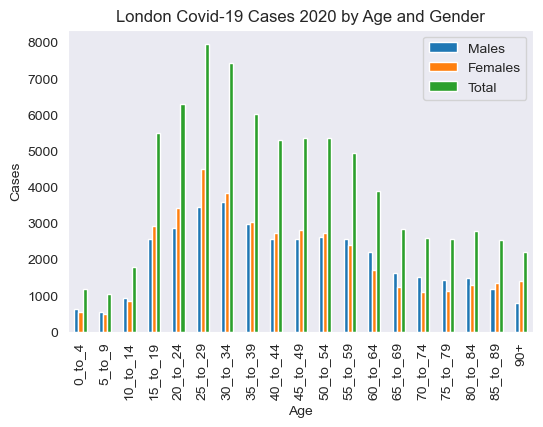

In [126]:
import seaborn as sns
sns.set_style("dark")
age_df.plot(kind='bar', y=['Males','Females','Total'])
plt.title("London Covid-19 Cases 2020 by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Cases")

Text(0, 0.5, 'Cases')

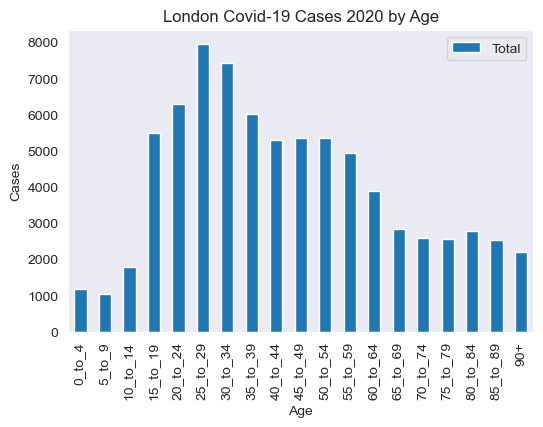

In [127]:
import seaborn as sns
sns.set_style("dark")
age_df.plot(kind='bar', y='Total')
plt.title("London Covid-19 Cases 2020 by Age")
plt.xlabel("Age")
plt.ylabel("Cases")